
# ![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

# Web Server Log Analysis with Spark SQL and DataFrames
 
 
Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

### Load the logs data

In [1]:
logsRDD = sc.textFile('hdfs:///user/gmedasani/data/exercises-data/apache.access.log')
logsRDD.take(5)

[u'in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0']

### Parse the logs using the below regex

In [2]:
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [3]:
import re
import datetime
from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline,"failed","","","","","","",0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (match.group(1),match.group(2),match.group(3),parse_apache_time(match.group(4)),match.group(5),match.group(6),
        match.group(7),int(match.group(8)),size)

In [4]:
parsedLogsRDD = logsRDD.map(parseApacheLogLine).cache()

In [5]:
accessLogsRDD = (parsedLogsRDD.filter(lambda s: s[1] != 'failed')
                .filter(lambda s: s[0])
                .cache())
accessLogsCount = accessLogsRDD.count()

In [6]:
print accessLogsCount

1043177


In [7]:
accessLogsRDD.take(4)

[(u'in24.inetnebr.com',
  u'-',
  u'-',
  datetime.datetime(1995, 8, 1, 0, 0, 1),
  u'GET',
  u'/shuttle/missions/sts-68/news/sts-68-mcc-05.txt',
  u'HTTP/1.0',
  200,
  1839L),
 (u'uplherc.upl.com',
  u'-',
  u'-',
  datetime.datetime(1995, 8, 1, 0, 0, 7),
  u'GET',
  u'/',
  u'HTTP/1.0',
  304,
  0L),
 (u'uplherc.upl.com',
  u'-',
  u'-',
  datetime.datetime(1995, 8, 1, 0, 0, 8),
  u'GET',
  u'/images/ksclogo-medium.gif',
  u'HTTP/1.0',
  304,
  0L),
 (u'uplherc.upl.com',
  u'-',
  u'-',
  datetime.datetime(1995, 8, 1, 0, 0, 8),
  u'GET',
  u'/images/MOSAIC-logosmall.gif',
  u'HTTP/1.0',
  304,
  0L)]

In [8]:
'''
(   host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size)
'''

'\n(   host          = match.group(1),\n        client_identd = match.group(2),\n        user_id       = match.group(3),\n        date_time     = parse_apache_time(match.group(4)),\n        method        = match.group(5),\n        endpoint      = match.group(6),\n        protocol      = match.group(7),\n        response_code = int(match.group(8)),\n        content_size  = size)\n'

## Create a Spark DataFrame from access logs RDD

In [8]:
from pyspark.sql import SQLContext, Row

In [9]:
print sqlContext

Spark SQL can convert an RDD of Row objects to a DataFrame, inferring the datatypes. Rows are constructed by passing a list of key/value pairs as kwargs to the Row class. The keys of this list define the column names of the table, and the types are inferred by looking at the first row. Since we currently only look at the first row, it is important that there is no missing data in the first row of the RDD. 

### Create an RDD with Row objects

In [10]:
accessLogsRowRDD = accessLogsRDD.map(lambda p: Row(host=p[0], 
                                                  client_identd=p[1],
                                                  user_id=p[2],
                                                  date_time=p[3],
                                                  method=p[4],
                                                  endpoint=p[5],
                                                  protocol=p[6],
                                                  response_code=int(p[7]),
                                                  content_size=long(p[8])))

In [11]:
accessLogsRowRDD.count()

1043177

In [12]:
accessLogsRowRDD.take(4)

[Row(client_identd=u'-', content_size=1839L, date_time=datetime.datetime(1995, 8, 1, 0, 0, 1), endpoint=u'/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', host=u'in24.inetnebr.com', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'),
 Row(client_identd=u'-', content_size=0L, date_time=datetime.datetime(1995, 8, 1, 0, 0, 7), endpoint=u'/', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'),
 Row(client_identd=u'-', content_size=0L, date_time=datetime.datetime(1995, 8, 1, 0, 0, 8), endpoint=u'/images/ksclogo-medium.gif', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'),
 Row(client_identd=u'-', content_size=0L, date_time=datetime.datetime(1995, 8, 1, 0, 0, 8), endpoint=u'/images/MOSAIC-logosmall.gif', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-')]

### Infer the schema, and register the DataFrame as a table.

In [13]:
accessLogsDF = sqlContext.createDataFrame(accessLogsRowRDD)

In [14]:
accessLogsDF

DataFrame[client_identd: string, content_size: bigint, date_time: timestamp, endpoint: string, host: string, method: string, protocol: string, response_code: bigint, user_id: string]

In [19]:
accessLogsDF.cache()
accessLogsDF.head(4)

[Row(client_identd=u'-', content_size=1839, date_time=datetime.datetime(1995, 8, 1, 0, 0, 1), endpoint=u'/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', host=u'in24.inetnebr.com', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'),
 Row(client_identd=u'-', content_size=0, date_time=datetime.datetime(1995, 8, 1, 0, 0, 7), endpoint=u'/', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'),
 Row(client_identd=u'-', content_size=0, date_time=datetime.datetime(1995, 8, 1, 0, 0, 8), endpoint=u'/images/ksclogo-medium.gif', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'),
 Row(client_identd=u'-', content_size=0, date_time=datetime.datetime(1995, 8, 1, 0, 0, 8), endpoint=u'/images/MOSAIC-logosmall.gif', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-')]

### Data Frame Operations

In [15]:
accessLogsDF.first()

Row(client_identd=u'-', content_size=1839, date_time=datetime.datetime(1995, 8, 1, 0, 0, 1), endpoint=u'/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', host=u'in24.inetnebr.com', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-')

In [16]:
accessLogsDF.columns

['client_identd',
 'content_size',
 'date_time',
 'endpoint',
 'host',
 'method',
 'protocol',
 'response_code',
 'user_id']

In [17]:
accessLogsDF.dtypes

[('client_identd', 'string'),
 ('content_size', 'bigint'),
 ('date_time', 'timestamp'),
 ('endpoint', 'string'),
 ('host', 'string'),
 ('method', 'string'),
 ('protocol', 'string'),
 ('response_code', 'bigint'),
 ('user_id', 'string')]

#### Computes statistics for numeric columns.

In [23]:
accessLogsDF.count()

1043177

## Sample Analysis

### Content Size statistics on the Web Server Log File

In [18]:
accessLogsDF.describe()

DataFrame[summary: string, content_size: string, response_code: string]

In [19]:
accessLogsDF.describe().show()

+-------+------------------+------------------+
|summary|      content_size|     response_code|
+-------+------------------+------------------+
|  count|           1043177|           1043177|
|   mean|17531.555702435926|210.77268287165074|
| stddev| 68561.96620052254|  33.5302820205224|
|    min|                 0|               200|
|    max|           3421948|               501|
+-------+------------------+------------------+



### Response Code Analysis

In [20]:
responseCodeCountDF = accessLogsDF.groupBy('response_code').count()
responseCodeCountDF

DataFrame[response_code: bigint, count: bigint]

In [21]:
responseCodeCountDF = responseCodeCountDF.withColumnRenamed('count','response_count')
responseCodeCountDF.columns

['response_code', 'response_count']

In [24]:
responseCodeCountDF.sort('count', ascending=False).collect()

[Row(response_code=200, response_count=940847),
 Row(response_code=304, response_count=79824),
 Row(response_code=302, response_count=16244),
 Row(response_code=404, response_count=6185),
 Row(response_code=403, response_count=58),
 Row(response_code=501, response_count=17),
 Row(response_code=500, response_count=2)]

### Response Code Graphing with matplotlib

In [25]:
totalNumberOfResponseCodes = responseCodeCountDF.select('response_count').groupBy().sum('response_count').collect()[0].asDict().values()[0]
print totalNumberOfResponseCodes

1043177


In [26]:
responseCodePercentRDD = responseCodeCountDF.map(lambda row: Row(response_code=row.response_code,
                                        response_code_pct= row.response_count/float(totalNumberOfResponseCodes)))
responseCodePercentDF = sqlContext.createDataFrame(responseCodePercentRDD)

In [27]:
responseCodePercentDF.collect()

[Row(response_code=500, response_code_pct=1.9172201841106543e-06),
 Row(response_code=501, response_code_pct=1.629637156494056e-05),
 Row(response_code=302, response_code_pct=0.015571662335346735),
 Row(response_code=304, response_code_pct=0.07652009198822443),
 Row(response_code=200, response_code_pct=0.9019054292799784),
 Row(response_code=403, response_code_pct=5.5599385339208974e-05),
 Row(response_code=404, response_code_pct=0.005929003419362198)]

In [28]:
responseCodePercentDFLocal = responseCodePercentDF.toPandas().sort('response_code_pct', ascending=False)

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


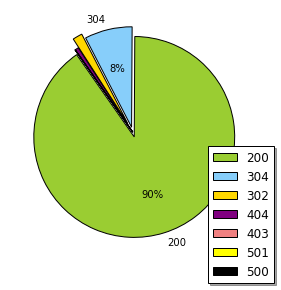

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(responseCodePercentDFLocal.response_code_pct, 
                                    labels=responseCodePercentDFLocal.response_code
                                    ,colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(responseCodePercentDFLocal.response_code, loc=(0.80, -0.1), shadow=True)
pass

### Frequent Hosts

In [30]:
hostCountDF = accessLogsDF.groupBy('host').count()
hostCountDF

DataFrame[host: string, count: bigint]

In [31]:
hostCountDF = hostCountDF.withColumnRenamed('count','host_count')
hostCountDF.columns

['host', 'host_count']

In [32]:
hostCountDFMoreThan10 = hostCountDF.filter('host_count >= 10')
hostCountDFMoreThan10.count()

25558

In [33]:
hostCountDFMoreThan10.sort('host_count', ascending=False).take(20)

[Row(host=u'edams.ksc.nasa.gov', host_count=4034),
 Row(host=u'piweba5y.prodigy.com', host_count=3237),
 Row(host=u'piweba4y.prodigy.com', host_count=3043),
 Row(host=u'piweba3y.prodigy.com', host_count=2830),
 Row(host=u'www-d1.proxy.aol.com', host_count=2715),
 Row(host=u'www-b3.proxy.aol.com', host_count=2518),
 Row(host=u'news.ti.com', host_count=2507),
 Row(host=u'www-b2.proxy.aol.com', host_count=2481),
 Row(host=u'163.206.89.4', host_count=2478),
 Row(host=u'www-c2.proxy.aol.com', host_count=2438),
 Row(host=u'www-c3.proxy.aol.com', host_count=2400),
 Row(host=u'www-d2.proxy.aol.com', host_count=2371),
 Row(host=u'www-d4.proxy.aol.com', host_count=2356),
 Row(host=u'www-b5.proxy.aol.com', host_count=2354),
 Row(host=u'www-b4.proxy.aol.com', host_count=2297),
 Row(host=u'www-d3.proxy.aol.com', host_count=2284),
 Row(host=u'www-a2.proxy.aol.com', host_count=2238),
 Row(host=u'www-c4.proxy.aol.com', host_count=2207),
 Row(host=u'www-c5.proxy.aol.com', host_count=2198),
 Row(host=u'

### Visualizing Endpoints

In [34]:
endPointsCountDF = accessLogsDF.groupBy('endpoint').count()
endPointsCountDF

DataFrame[endpoint: string, count: bigint]

In [35]:
endPointsCountDF = endPointsCountDF.withColumnRenamed('count','endpoint_count')
endPointsCountDF.columns

['endpoint', 'endpoint_count']

In [39]:
endPointsCountDFLocal = endPointsCountDF.toPandas()
endPointsCountDFLocal.head()

,endpoint,endpoint_count
0,/history/apollo/apollo-11/images/,304
1,/shuttle/technology/sts-newsref/sts-apu.html,235
2,/shuttle/missions/sts-71/images/KSC-95EC-0950.jpg,115
3,/htbin/wais.pl?APU+AND+ANOMALY,2
4,/shuttle/countdown/lps/images/BKUP-INT-large.gif,6


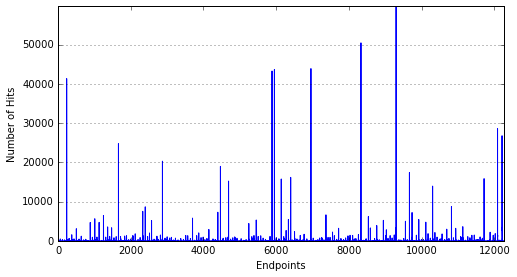

In [40]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(endPointsCountDFLocal.endpoint.tolist()), 0, max(endPointsCountDFLocal.endpoint_count.tolist())])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(endPointsCountDFLocal.endpoint_count)
pass

### Top Endpoints

In [41]:
top10EndPoints = endPointsCountDF.sort('endpoint_count',ascending=False).take(10)
top10EndPoints

[Row(endpoint=u'/images/NASA-logosmall.gif', endpoint_count=59737),
 Row(endpoint=u'/images/KSC-logosmall.gif', endpoint_count=50452),
 Row(endpoint=u'/images/MOSAIC-logosmall.gif', endpoint_count=43890),
 Row(endpoint=u'/images/USA-logosmall.gif', endpoint_count=43664),
 Row(endpoint=u'/images/WORLD-logosmall.gif', endpoint_count=43277),
 Row(endpoint=u'/images/ksclogo-medium.gif', endpoint_count=41336),
 Row(endpoint=u'/ksc.html', endpoint_count=28582),
 Row(endpoint=u'/history/apollo/images/apollo-logo1.gif', endpoint_count=26778),
 Row(endpoint=u'/images/launch-logo.gif', endpoint_count=24755),
 Row(endpoint=u'/', endpoint_count=20292)]

### Deeper Analysis of Web Server Logs

#### Top 10 error end points

In [42]:
errorEndPointsDF = accessLogsDF.filter('response_code != 200')
print errorEndPointsDF.count()
errorEndPointsDF

102330


DataFrame[client_identd: string, content_size: bigint, date_time: timestamp, endpoint: string, host: string, method: string, protocol: string, response_code: bigint, user_id: string]

In [43]:
errorEndPointsCountDF = errorEndPointsDF.groupBy('endpoint').count().withColumnRenamed('count','endpoint_count')
topTenErrURLs = errorEndPointsCountDF.sort('endpoint_count', ascending=False).take(10)
topTenErrURLs

[Row(endpoint=u'/images/NASA-logosmall.gif', endpoint_count=8761),
 Row(endpoint=u'/images/KSC-logosmall.gif', endpoint_count=7236),
 Row(endpoint=u'/images/MOSAIC-logosmall.gif', endpoint_count=5197),
 Row(endpoint=u'/images/USA-logosmall.gif', endpoint_count=5157),
 Row(endpoint=u'/images/WORLD-logosmall.gif', endpoint_count=5020),
 Row(endpoint=u'/images/ksclogo-medium.gif', endpoint_count=4728),
 Row(endpoint=u'/history/apollo/images/apollo-logo1.gif', endpoint_count=2907),
 Row(endpoint=u'/images/launch-logo.gif', endpoint_count=2811),
 Row(endpoint=u'/', endpoint_count=2199),
 Row(endpoint=u'/images/ksclogosmall.gif', endpoint_count=1622)]

#### Number of Unique hosts

In [44]:
accessLogsDF.select('host').distinct().count()

54507

#### Number of Unique Daily Hosts

In [45]:
dayHostDF = sqlContext.createDataFrame(accessLogsDF.map(lambda row: Row(day=row.date_time.day,host=row.host)))
dayHostDF.cache()
dayHostDF

DataFrame[day: bigint, host: string]

In [46]:
dayHostDF.take(10)

[Row(day=1, host=u'in24.inetnebr.com'),
 Row(day=1, host=u'uplherc.upl.com'),
 Row(day=1, host=u'uplherc.upl.com'),
 Row(day=1, host=u'uplherc.upl.com'),
 Row(day=1, host=u'uplherc.upl.com'),
 Row(day=1, host=u'ix-esc-ca2-07.ix.netcom.com'),
 Row(day=1, host=u'uplherc.upl.com'),
 Row(day=1, host=u'slppp6.intermind.net'),
 Row(day=1, host=u'piweba4y.prodigy.com'),
 Row(day=1, host=u'slppp6.intermind.net')]

In [49]:
dayUniqueHostCountDF = (dayHostDF.distinct().groupBy('day').count().withColumnRenamed('count','unique_host_count')
                 .sort('day'))
dayUniqueHostCountDF.collect()

[Row(day=1, unique_host_count=2582),
 Row(day=3, unique_host_count=3222),
 Row(day=4, unique_host_count=4190),
 Row(day=5, unique_host_count=2502),
 Row(day=6, unique_host_count=2537),
 Row(day=7, unique_host_count=4106),
 Row(day=8, unique_host_count=4406),
 Row(day=9, unique_host_count=4317),
 Row(day=10, unique_host_count=4523),
 Row(day=11, unique_host_count=4346),
 Row(day=12, unique_host_count=2864),
 Row(day=13, unique_host_count=2650),
 Row(day=14, unique_host_count=4454),
 Row(day=15, unique_host_count=4214),
 Row(day=16, unique_host_count=4340),
 Row(day=17, unique_host_count=4385),
 Row(day=18, unique_host_count=4168),
 Row(day=19, unique_host_count=2550),
 Row(day=20, unique_host_count=2560),
 Row(day=21, unique_host_count=4134),
 Row(day=22, unique_host_count=4456)]

### Average Number of Daily Requests by host

In [51]:
dayRequestCountDF = dayHostDF.groupBy('day').count().withColumnRenamed('count','requests_count').sort('day')
dayRequestCountDF.collect()

[Row(day=1, requests_count=33996),
 Row(day=3, requests_count=41387),
 Row(day=4, requests_count=59554),
 Row(day=5, requests_count=31888),
 Row(day=6, requests_count=32416),
 Row(day=7, requests_count=57355),
 Row(day=8, requests_count=60142),
 Row(day=9, requests_count=60457),
 Row(day=10, requests_count=61245),
 Row(day=11, requests_count=61242),
 Row(day=12, requests_count=38070),
 Row(day=13, requests_count=36480),
 Row(day=14, requests_count=59873),
 Row(day=15, requests_count=58845),
 Row(day=16, requests_count=56651),
 Row(day=17, requests_count=58980),
 Row(day=18, requests_count=56244),
 Row(day=19, requests_count=32092),
 Row(day=20, requests_count=32963),
 Row(day=21, requests_count=55539),
 Row(day=22, requests_count=57758)]

In [53]:
dayHostsAndRequestsCountDF = dayRequestCountDF.join(dayUniqueHostCountDF, on='day', how ='inner')
dayHostsAndRequestsCountDF.collect()

[Row(day=1, requests_count=33996, unique_host_count=2582),
 Row(day=3, requests_count=41387, unique_host_count=3222),
 Row(day=4, requests_count=59554, unique_host_count=4190),
 Row(day=5, requests_count=31888, unique_host_count=2502),
 Row(day=6, requests_count=32416, unique_host_count=2537),
 Row(day=7, requests_count=57355, unique_host_count=4106),
 Row(day=8, requests_count=60142, unique_host_count=4406),
 Row(day=9, requests_count=60457, unique_host_count=4317),
 Row(day=10, requests_count=61245, unique_host_count=4523),
 Row(day=11, requests_count=61242, unique_host_count=4346),
 Row(day=12, requests_count=38070, unique_host_count=2864),
 Row(day=13, requests_count=36480, unique_host_count=2650),
 Row(day=14, requests_count=59873, unique_host_count=4454),
 Row(day=15, requests_count=58845, unique_host_count=4214),
 Row(day=16, requests_count=56651, unique_host_count=4340),
 Row(day=17, requests_count=58980, unique_host_count=4385),
 Row(day=18, requests_count=56244, unique_host_c

In [54]:
dayHostsAndRequestsCountDF.registerTempTable('dayHostsAndRequestsTable')

In [62]:
avgDailyRequestPerHost = sqlContext.sql("select day,requests_count/unique_host_count as avg_requests_per_host from dayHostsAndRequestsTable")

In [63]:
avgDailyRequestPerHost.collect()

[Row(day=1, avg_requests_per_host=13.166537567776917),
 Row(day=3, avg_requests_per_host=12.845127250155183),
 Row(day=4, avg_requests_per_host=14.213365155131266),
 Row(day=5, avg_requests_per_host=12.745003996802557),
 Row(day=6, avg_requests_per_host=12.777296018919984),
 Row(day=7, avg_requests_per_host=13.968582562104238),
 Row(day=8, avg_requests_per_host=13.650022696323196),
 Row(day=9, avg_requests_per_host=14.00440120454019),
 Row(day=10, avg_requests_per_host=13.540791510059695),
 Row(day=11, avg_requests_per_host=14.091578462954441),
 Row(day=12, avg_requests_per_host=13.292597765363128),
 Row(day=13, avg_requests_per_host=13.766037735849057),
 Row(day=14, avg_requests_per_host=13.442523574315222),
 Row(day=15, avg_requests_per_host=13.964167062173706),
 Row(day=16, avg_requests_per_host=13.053225806451612),
 Row(day=17, avg_requests_per_host=13.450399087799315),
 Row(day=18, avg_requests_per_host=13.494241842610364),
 Row(day=19, avg_requests_per_host=12.585098039215687),
 